# Système de recommandation de livres basé sur le contenu

# Cahier des charges

Projet : Système de recommandation de livres

Objectif : 
- Prédire les livres qu'un utilisateur pourrait aimer en fonction de ses préférences (recommandation collaborative) et des similarités avec d'autres livres (recommandation basée sur le contenu)

Techniques Utilisées :
- Filtrage collaboratif (basé-mémoire/basé-modèle)
- Recommandation basée sur le contenu (TF-IDF, embeddings : Word2Vec, GloVe, etc)
- Modèles : KNN, SVD, NMF, etc

Étapes :

Dataset
- Utiliser : https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
- Tester d’autres datasets de recommandation de livres

Prétraitement
- Nettoyage des données (valeurs manquantes, doublons)
- Feature engineering (genres, auteurs, notes moyennes)
- Vectorisation des textes (titres, descriptions) avec TF-IDF, Word2Vec, GloVe, etc

Algorithmes
- Collaboratif : matrice utilisateur-livre, SVD, NMF, KNN, etc
- Basé sur le contenu : similarité cosinus sur les features textuelles

In [1]:
import pandas as pd
import numpy as np
import os
from surprise import Dataset, Reader, SVD
from tqdm import tqdm
import json
import psycopg2
import re
import ast
import nltk
import gensim
from nltk.corpus import stopwords

In [2]:
path = "./datasets/"

books = pd.read_csv(path+"Books.csv")
users= pd.read_csv(path+"Users.csv")
ratings = pd.read_csv(path+"Ratings.csv")

In [3]:
def save_df_to_csv(df, path):
    """ Crée un fichier csv à partir d'un dataframe.
        Arguments :
            df (DataFrame)
            path (str) : chemin du fichier qui sera créé.
    """
    df.to_csv(path, index=False, header=True)

def save_df_to_pickle(df, path):
    """ Crée un fichier pkl à partir d'un dataframe. C'est pour garder le type list des sujets et descriptions.
        Arguments :
            df (DataFrame)
            path (str) : chemin du fichier qui sera créé.
    """
    df.to_pickle(path)

In [4]:
books.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [5]:
ratings.columns

Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')

In [6]:
users.columns

Index(['User-ID', 'Location', 'Age'], dtype='object')

In [7]:
books.rename(columns={'Book-Title':'title', 'Book-Author': 'author','Year-Of-Publication':'year', 'Publisher':'publisher'}, inplace=True)
books.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], inplace=True)
books.head(10)

,ISBN,title,author,year,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group
7,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks
8,0679425608,Under the Black Flag: The Romance and the Real...,David Cordingly,1996,Random House
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner


In [8]:
ratings.rename(columns={'User-ID':'user_id', 'Book-Rating':'rating'}, inplace=True)
ratings.head(10)

,user_id,ISBN,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
6,276736,3257224281,8
7,276737,0600570967,6
8,276744,038550120X,7
9,276745,342310538,10


In [9]:
users.rename(columns={'User-ID':'user_id', 'Location':'location','Age':'age'}, inplace=True)
users.head(10)

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
5,6,"santa monica, california, usa",61.0
6,7,"washington, dc, usa",NaN
7,8,"timmins, ontario, canada",NaN
8,9,"germantown, tennessee, usa",NaN
9,10,"albacete, wisconsin, spain",26.0


## Préparation des données

In [23]:
nb_ratings=ratings['user_id'].value_counts() > 100
nb_ratings

user_id
11676      True
198711     True
153662     True
98391      True
35859      True
          ...  
116180    False
116166    False
116154    False
116137    False
276723    False
Name: count, Length: 105283, dtype: bool

In [10]:
nb_ratings[nb_ratings].shape

(1825,)

In [11]:
nb_users=nb_ratings[nb_ratings].index
nb_users

Index([ 11676, 198711, 153662,  98391,  35859, 212898, 278418,  76352, 110973,
       235105,
       ...
       238186,  99441, 187410, 262070,  70183,  40553,  39345, 266283, 189666,
       140879],
      dtype='int64', name='user_id', length=1825)

In [12]:
ratings_filtered=ratings[ratings['user_id'].isin(nb_users)]
ratings_filtered

,user_id,ISBN,rating
412,276925,0006511929,0
413,276925,002542730X,10
414,276925,0060520507,0
415,276925,0060930934,0
416,276925,0060951303,0
...,...,...,...
1149633,276680,1884910033,0
1149634,276680,1888173408,7
1149635,276680,1888173564,8
1149636,276680,1888173572,0


In [14]:
def show_image(url, width=100):
    """ Affiche les images du dataset"""
    return f'<img src="{url}" width="{width}">'

def url_to_img(df, func):
    return df.style.format({'Image-URL-S':func, 'Image-URL-M':func, 'Image-URL-L':func}, escape=False)

In [15]:
books.isnull().sum()

ISBN         0
title        0
author       2
year         0
publisher    2
dtype: int64

In [16]:
books.dropna(inplace=True)
books.isnull().sum()

ISBN         0
title        0
author       0
year         0
publisher    0
dtype: int64

In [17]:
books.shape

(271356, 5)

lignes a verif :

- 118033
- 128890
- 129037
- 187689
- 209540
- 220731
- 221678

In [18]:
books.duplicated().sum()

0

In [19]:
ratings.isnull().sum()

user_id    0
ISBN       0
rating     0
dtype: int64

In [20]:
ratings.duplicated().sum()

0

In [21]:
ratings['user_id'].value_counts()

user_id
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
116180        1
116166        1
116154        1
116137        1
276723        1
Name: count, Length: 105283, dtype: int64

In [22]:
users.isnull().sum()

user_id          0
location         0
age         110762
dtype: int64

In [23]:
users.shape

(278858, 3)

## Feature engineering 

- Ajout des genres et descritpion (si possible) des livres dans le dataset
- Ajout de la note moyenne de chaque livre
- Ajout de la note moyenne de l'utilisateur 
- Ajout du nombre de notes de chaque livre
- Fusion des datasets pour en avoir un basé sur les utilisateurs avec leurs notes moyennes et celles des livres

### API openlibrary (tests)

In [10]:
import pandas as pd
import requests
import time

# Utiliser les 10 premiers ISBNs pour test
isbns = books['ISBN'].dropna().unique()

# Stocker les genres extraits
extracted_genres = []

for isbn in isbns:
    try:
        url = f"https://openlibrary.org/api/books?bibkeys=ISBN:{isbn}&jscmd=details&format=json"
        response = requests.get(url)
        data = response.json()

        key = f"ISBN:{isbn}"
        genres = data.get(key, {}).get('details', {}).get('subjects', [])
        
        # Extraire les noms des genres
        genres_list = [g['name'] if isinstance(g, dict) else g for g in genres]

        extracted_genres.append({
            'ISBN': isbn,
            'genres_from_api': ', '.join(genres_list)
        })

        # Pause pour éviter d’être bloqué par l’API
        time.sleep(1)

    except Exception as e:
        extracted_genres.append({'ISBN': isbn, 'genres_from_api': None})
        print(f"Erreur avec ISBN {isbn} : {e}")

# Convertir en DataFrame et enregistrer
genres_df = pd.DataFrame(extracted_genres)
genres_df.to_csv("genres_from_openlibrary.csv", index=False)

print("✅ Extraction terminée !")


ModuleNotFoundError: No module named 'requests'

### Ajout des genres et description en utilisant les dumps d'openlibrary

Avant de faire ça, j'ai créé une base de données avec postgresql grâce à : https://github.com/LibrariesHacked/openlibrary-search

In [24]:
def get_key_books(isbn_list):
    """ Permet de récupérer une liste de key de la table 'editions' pour chaque isbn de la liste. 
        (C'est une liste de listes de key).
        Arguments :
            isbn_list (str[]) : liste d'isbn
    """
    conn = psycopg2.connect(
        dbname='openlibrary',
        user='user',
        password='password',
        host='localhost',
        port='5432'
    )
    conn.autocommit = True
    cur = conn.cursor()

    sql = """
        SELECT e.key
        FROM editions e
        JOIN edition_isbns ei ON ei.edition_key = e.key
        WHERE ei.isbn = %s
    """

    key_books = []
    for isbn in tqdm(isbn_list):
        cur.execute(sql, (isbn,))
        results = cur.fetchall()
        key_books.append(results)

    cur.close()
    conn.close()

    return key_books

In [25]:
def get_key_books_list(isbn_list):
    """ Renvoie une liste de key de la table 'editions' correspondant aux isbn donnés.
        Arguments :
            isbn_list (str[]) : liste d'isbn
    """
    conn = psycopg2.connect(
        dbname='openlibrary',
        user='user',
        password='password',
        host='localhost',
        port='5432'
    )
    conn.autocommit = True
    cur = conn.cursor()

    sql = """
        SELECT e.key
        FROM editions e
        JOIN edition_isbns ei ON ei.edition_key = e.key
        WHERE ei.isbn = %s
    """

    key_books = []
    for isbn in tqdm(isbn_list):
        cur.execute(sql, (isbn,))
        results = cur.fetchall()
        key_books.extend([r[0] for r in results])

    cur.close()
    conn.close()

    return key_books

In [26]:
isbn_list=books['ISBN']
isbn_list

0         0195153448
1         0002005018
2         0060973129
3         0374157065
4         0393045218
             ...    
271355    0440400988
271356    0525447644
271357    006008667X
271358    0192126040
271359    0767409752
Name: ISBN, Length: 271356, dtype: object

In [49]:
keys=get_key_books_list(isbn_list)

100%|██████████| 271356/271356 [04:17<00:00, 1054.76it/s]


In [50]:
keys_books=get_key_books(isbn_list)

100%|██████████| 271356/271356 [03:54<00:00, 1157.51it/s]


In [51]:
keys[:10]

['/books/OL18389036M',
 '/books/OL22232624M',
 '/books/OL7390154M',
 '/books/OL3597106M',
 '/books/OL22133369M',
 '/books/OL1890897M',
 '/books/OL20945359M',
 '/books/OL7423081M',
 '/books/OL23243677M',
 '/books/OL358977M']

In [52]:
keys_books[:10]

[[('/books/OL18389036M',), ('/books/OL22232624M',), ('/books/OL7390154M',)],
 [('/books/OL3597106M',), ('/books/OL22133369M',)],
 [('/books/OL1890897M',), ('/books/OL20945359M',)],
 [('/books/OL7423081M',), ('/books/OL23243677M',)],
 [('/books/OL358977M',)],
 [('/books/OL1530439M',)],
 [('/books/OL7504546M',), ('/books/OL24223668M',)],
 [('/books/OL27242140M',)],
 [('/books/OL804879M',)],
 [('/books/OL3659400M',)]]

In [53]:
books_with_keys=pd.DataFrame({
    'ISBN': isbn_list,
    'key_book': keys_books
}, columns=['ISBN', 'key_book'])

In [57]:
# Sauvegarde du dataframe pour ne plus faire l'opération

save_df_to_csv(books_with_keys, './datasets/isbn_with_OLkey.csv') 

La base a été créée. On cherche maintenant à relier les editions à un work correspondant. Les editions peuvent avoir dans leur champ data (fichier json) une colonne work qui contient une clé key de la table works. Comme le nombre d'edition est massif, un index a d'abord été fait sur edition_isbns (table reliant les editions à leur isbn) pour accélérer le temps des requêtes. Ensuite grâce à la fonction get_key_books_list au-dessus, on récupère uniquement les clés des livres de notre dataset initial. La fonction update_editions_work_key ci-dessous permet de faire la liaison entre l'edition et le work uniquement aux livres concernés. 

In [27]:
def update_editions_work_key(keys_list):
    conn = psycopg2.connect(
        dbname='openlibrary',
        user='user',
        password='password',
        host='localhost',
        port='5432'
    )
    conn.autocommit = True
    cur = conn.cursor()

    query = """
        UPDATE editions
        SET work_key = data->'works'->0->>'key'
        WHERE key = %s;
    """

    for key in tqdm(keys_list):
        cur.execute(query, (key,))

    cur.close()
    conn.close()

In [ ]:
update_editions_work_key(keys)

100%|██████████| 367546/367546 [13:09<00:00, 465.64it/s] 


Maintenant, on peut récupérer les informations que l'on souhaite pour chacun des livres de notre dataset avec la fonction get_infos_by_isbn_list.

In [28]:
def split_subject_words(subject):
    """ Permet de séparer les mots tout en ignorant la ponctuation et les espaces. 
        On met aussi en minuscule les mots pour éciter la casse.
        Arguments :
            subject (str) : liste de genres retournés lors de la requête sql
    """
    return re.findall(r'\b\w+\b', subject.lower())

def get_infos_by_isbn_list(isbn_list):
    conn = psycopg2.connect(
        dbname='openlibrary',
        user='user', 
        password='password', 
        host='localhost',
        port='5432'
    )
    conn.autocommit = True
    cur = conn.cursor()

    # Requête sql permettant de récupérer les genres et descriptions d'un livre via son isbn
    sql = """
        select
        e.data->>'subjects' "Subjects",
        w.data->'description'->>'value' "WorkDescription"
    from editions e
    join edition_isbns ei
        on ei.edition_key = e.key
    join works w
        on w.key = e.work_key
    where ei.isbn = %s
    """

    # Comme on peut avoir plusieurs résultats pour un même isbn, 
    # la requête renverra plusieurs fois des subjects et descriptions (assez souvent identiques)
    # On traite de ce cas juste après
    
    subjects_final= [] # liste de listes qui contiendra les genres recueillis de chaque livre
    desc_final=[] # liste des descriptions des livres

    for isbn in tqdm(isbn_list):
        cur.execute(sql, (isbn,))
        results = cur.fetchall()

        # On crée ici des sets pour éviter les doublons lors de l'ajout des genres ou descriptions
        all_words = set()
        description_set = set()

        for r in results:
            
            if r[0]:
                subjects_list = json.loads(r[0]) 
                for subject in subjects_list:
                    words = split_subject_words(subject) # On sépare les mots des listes de genres qu'on obtient 
                                                         # pour comparer avec les suivants et ne pas ajouter de doublon
                    for w in words:
                        all_words.add(w)

            
            if r[1]:
                description_set.add(r[1])

        subjects_words = list(all_words)
        descriptions = list(description_set)
        subjects_final.append(subjects_words)
        desc_final.append(descriptions)

    cur.close()
    conn.close()

    return subjects_final, desc_final


In [59]:
subjects, description=get_infos_by_isbn_list(isbn_list)

100%|██████████| 271356/271356 [09:23<00:00, 481.44it/s]


In [263]:
books_desc=pd.DataFrame({
    'ISBN': isbn_list,
    'sujets': subjects,
    'description': description
})

In [264]:
books_desc

,ISBN,sujets,description
0,0195153448,"[mythology, classical]",[An excellent primer on classical mythology fo...
1,0002005018,"[york, ontario, teachers, sisters, fiction, ac...","[E-book extras: ""Hero of the Humdrum"": A profi..."
2,0060973129,"[war, 1945, campaigns, world, france, history,...",[]
3,0374157065,"[century, influenza, 20th, history]","[The fascinating, true story of the world's de..."
4,0393045218,"[age, basin, prehistoric, tarim, zizhiqu, mumm...","[In the museums of Urumchi, the wind-swept reg..."
...,...,...,...
271355,0440400988,"[juvenile, camps, fiction]","[On her own for the first time, fourteen-year-..."
271356,0525447644,"[juvenile, counting, literature]",[Illustrations of people and animals introduce...
271357,006008667X,"[century, states, american, alternate, history...","[In Lily Dale, New York, the dead don't die. I..."
271358,0192126040,"[works, utopias, early, science, 1800, to, pol...",[The Republic is Plato's most famous work and ...


In [29]:
import ast
import json

def str_to_list_auto(val):
    if isinstance(val, list):
        return val  # déjà une liste
    if val is None or val == '':
        return []
    try:
        # Essaye JSON (["a", "b"])
        return json.loads(val)
    except (json.JSONDecodeError, TypeError):
        try:
            # Essaye une liste Python ("['a', 'b']")
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            # Sinon, split sur virgule simple
            return [x.strip() for x in val.split(',') if x.strip()]



In [311]:
books_desc['sujets']=books_desc['sujets'].apply(str_to_list_auto)
books_desc['description']=books_desc['description'].apply(str_to_list_auto)

In [316]:
save_df_to_pickle(books_desc, './datasets/books_desc.pkl')

In [317]:
save_df_to_csv(books_desc, './datasets/books_desc.csv')

In [24]:
books_desc=pd.read_pickle('./datasets/books_desc.pkl')

In [25]:
books_desc.head()

,ISBN,sujets,description
0,0195153448,"[mythology, classical]",[An excellent primer on classical mythology fo...
1,0002005018,"[york, ontario, teachers, sisters, fiction, ac...","[E-book extras: ""Hero of the Humdrum"": A profi..."
2,0060973129,"[war, 1945, campaigns, world, france, history,...",[]
3,0374157065,"[century, influenza, 20th, history]","[The fascinating, true story of the world's de..."
4,0393045218,"[age, basin, prehistoric, tarim, zizhiqu, mumm...","[In the museums of Urumchi, the wind-swept reg..."


En voyant les premières lignes du DataFrame, on remarque des listes vides si la description ou les sujets ne sont pas trouvables. On va donc chercher ceux qui ont au moins une description ou au moins des sujets.

In [26]:
books_desc_non_empty = books_desc[
    books_desc['description'].apply(lambda x: len(x) > 0) |
    books_desc['sujets'].apply(lambda x: len(x) > 0)
]


In [27]:
books_desc_non_empty

,ISBN,sujets,description
0,0195153448,"[mythology, classical]",[An excellent primer on classical mythology fo...
1,0002005018,"[york, ontario, teachers, sisters, fiction, ac...","[E-book extras: ""Hero of the Humdrum"": A profi..."
2,0060973129,"[war, 1945, campaigns, world, france, history,...",[]
3,0374157065,"[century, influenza, 20th, history]","[The fascinating, true story of the world's de..."
4,0393045218,"[age, basin, prehistoric, tarim, zizhiqu, mumm...","[In the museums of Urumchi, the wind-swept reg..."
...,...,...,...
271351,0440400988,"[juvenile, camps, fiction]","[On her own for the first time, fourteen-year-..."
271352,0525447644,"[juvenile, counting, literature]",[Illustrations of people and animals introduce...
271353,006008667X,"[century, states, american, alternate, history...","[In Lily Dale, New York, the dead don't die. I..."
271354,0192126040,"[works, utopias, early, science, 1800, to, pol...",[The Republic is Plato's most famous work and ...


In [34]:
save_df_to_csv(books_desc_non_empty, './datasets/books_desc_non_empty.csv')

In [35]:
save_df_to_pickle(books_desc_non_empty, './datasets/books_desc_non_empty.pkl')

In [30]:
books_desc_non_empty=pd.read_pickle('./datasets/books_desc_non_empty.pkl')

In [37]:
nltk.download('stopwords') # pour télécharger les stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\solut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
stop_words = set(stopwords.words('english'))

def clean_subject_words(subjects):
    """ Enlève les stop words et mots trop courts de la liste de sujets
        subjects (str[]) : liste de sujets
    """

    cleaned = []
    for subject in subjects:
        words = re.findall(r'\b\w+\b', subject.lower())
        filtered = [word for word in words if word not in stop_words and len(word) > 2]
        cleaned.extend(filtered)

    return list(set(cleaned)) 

In [39]:
books_desc_non_empty['sujets']=books_desc_non_empty['sujets'].apply(clean_subject_words)

In [40]:
books_desc_non_empty=books_desc_non_empty.reset_index(drop=True)

In [41]:
books_desc_non_empty

,ISBN,sujets,description
0,0195153448,"[mythology, classical]",[An excellent primer on classical mythology fo...
1,0002005018,"[ontario, women, fiction, young, new, teachers...","[E-book extras: ""Hero of the Humdrum"": A profi..."
2,0060973129,"[normandy, war, history, world, 1939, 1945, fr...",[]
3,0374157065,"[influenza, century, history, 20th]","[The fascinating, true story of the world's de..."
4,0393045218,"[basin, age, prehistoric, antiquities, xinjian...","[In the museums of Urumchi, the wind-swept reg..."
...,...,...,...
217901,0440400988,"[fiction, juvenile, camps]","[On her own for the first time, fourteen-year-..."
217902,0525447644,"[counting, juvenile, literature]",[Illustrations of people and animals introduce...
217903,006008667X,"[century, 20th, united, history, spiritualism,...","[In Lily Dale, New York, the dead don't die. I..."
217904,0192126040,"[1800, early, utopias, political, science, works]",[The Republic is Plato's most famous work and ...


In [42]:
save_df_to_csv(books_desc_non_empty, './datasets/books_desc_non_empty.csv')

In [ ]:
save_df_to_pickle(books_desc_non_empty, './datasets/books_desc_non_empty.pkl')

In [6]:
books_desc_subj = books_desc[
    (books_desc['description'].apply(lambda x: len(x) > 0)) &
    (books_desc['sujets'].apply(lambda x: len(x) > 0))
]

In [13]:
books_desc_subj=books_desc_subj.reset_index(drop=True)

In [14]:
books_desc_subj

,ISBN,sujets,description
0,0195153448,"[mythology, classical]",[An excellent primer on classical mythology fo...
1,0002005018,"[york, ontario, teachers, sisters, fiction, ac...","[E-book extras: ""Hero of the Humdrum"": A profi..."
2,0374157065,"[century, influenza, 20th, history]","[The fascinating, true story of the world's de..."
3,0393045218,"[age, basin, prehistoric, tarim, zizhiqu, mumm...","[In the museums of Urumchi, the wind-swept reg..."
4,0425176428,"[imaginary, battles, histories, wars, and]",[With its in-depth reflections on the monument...
...,...,...,...
64107,014002803X,"[general, modern, fiction]","[Amid preparations for Operation Apollo, secre..."
64108,0440400988,"[juvenile, camps, fiction]","[On her own for the first time, fourteen-year-..."
64109,0525447644,"[juvenile, counting, literature]",[Illustrations of people and animals introduce...
64110,006008667X,"[century, states, american, alternate, history...","[In Lily Dale, New York, the dead don't die. I..."


In [47]:
books_desc_subj['sujets']=books_desc_subj['sujets'].apply(clean_subject_words)

In [48]:
save_df_to_csv(books_desc_subj, './datasets/books_desc_subj.csv')

In [49]:
save_df_to_pickle(books_desc_subj,  './datasets/books_desc_subj.pkl')

Maintenant on fusionne le dernier dataset avec books.

In [60]:
books_final=books.merge(books_desc_non_empty, on='ISBN')

In [50]:
books_without_void=books.merge(books_desc_subj, on='ISBN')

In [30]:
books_final

,ISBN,title,author,year,publisher,sujets,description
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,"['mythology', 'classical']",['An excellent primer on classical mythology f...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,"['ontario', 'women', 'fiction', 'young', 'new'...","['E-book extras: ""Hero of the Humdrum"": A prof..."
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"['normandy', 'war', 'history', 'world', '1939'...",[]
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"['influenza', 'century', 'history', '20th']","[""The fascinating, true story of the world's d..."
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,"['basin', 'age', 'prehistoric', 'antiquities',...","['In the museums of Urumchi, the wind-swept re..."
...,...,...,...,...,...,...,...
217901,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),"['fiction', 'juvenile', 'camps']","['On her own for the first time, fourteen-year..."
217902,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,"['counting', 'juvenile', 'literature']",['Illustrations of people and animals introduc...
217903,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,"['century', '20th', 'united', 'history', 'spir...","['In Lily Dale, New York, the dead don\'t die...."
217904,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,"['1800', 'early', 'utopias', 'political', 'sci...","[""The Republic is Plato's most famous work and..."


In [84]:
save_df_to_csv(books_final, './datasets/books_final.csv')

NameError: name 'save_df_to_csv' is not defined

In [85]:
books_final=pd.read_csv('./datasets/books_final.csv')

In [86]:
books_final.head()

,ISBN,title,author,year,publisher,sujets,description
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,"['mythology', 'classical']",['An excellent primer on classical mythology f...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,"['ontario', 'women', 'fiction', 'young', 'new'...","['E-book extras: ""Hero of the Humdrum"": A prof..."
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"['normandy', 'war', 'history', 'world', '1939'...",[]
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"['influenza', 'century', 'history', '20th']","[""The fascinating, true story of the world's d..."
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,"['basin', 'age', 'prehistoric', 'antiquities',...","['In the museums of Urumchi, the wind-swept re..."


In [51]:
books_without_void.head()

,ISBN,title,author,year,publisher,sujets,description
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,"[classical, mythology]",[An excellent primer on classical mythology fo...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,"[women, ontario, actresses, young, teachers, y...","[E-book extras: ""Hero of the Humdrum"": A profi..."
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"[century, influenza, 20th, history]","[The fascinating, true story of the world's de..."
3,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,"[mummies, prehistoric, antiquities, tarim, tex...","[In the museums of Urumchi, the wind-swept reg..."
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,"[imaginary, histories, wars, battles]",[With its in-depth reflections on the monument...


In [52]:
save_df_to_csv(books_without_void, './datasets/books_without_void.csv')

In [53]:
books_without_void=pd.read_csv('./datasets/books_without_void.csv')

### Création du dataset pour la recommandation basée sur le contenu

In [31]:
book_rating = ratings.groupby('ISBN')['rating'].mean().reset_index()
book_rating.head()

,ISBN,rating
0,0330299891,3.0
1,0375404120,1.5
2,0586045007,0.0
3,9022906116,3.5
4,9032803328,0.0


In [32]:
rating_books=ratings.merge(books_final, on='ISBN')

rating_books

,user_id,ISBN,rating,title,author,year,publisher,sujets,description
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"['fiction', 'new', 'trials', 'york', 'murder']",[]
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,"['problems', 'college', 'readers', 'etc', 'exe...",[]
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,"['people', 'fiction', 'north', 'oral', 'caroli...",[]
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,"['language', 'dictionaries', 'graded', 'fictio...",[]
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,"['second', 'books', 'phrase', 'textbooks', 'la...",[]
...,...,...,...,...,...,...,...,...,...
874980,276704,0876044011,0,Edgar Cayce on the Akashic Records: The Book o...,Kevin J. Todeschi,1998,A.R.E. Press (Association of Research &amp; Enlig,"['records', 'akashic', 'edgar', '1945', '1877'...",[]
874981,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press,"['reference', 'education', 'economics', 'help'...",['Provides consumers an array of solutions to ...
874982,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997,Alfred A. Knopf,"['medicine', 'behavior', 'care', 'health', 'al...","[""Now expanded and updated: The book in which ..."
874983,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books,"['romance', 'nobility', 'regency', 'ghost', 'h...","[""Douglas Sherbrooke, Earl of Northcliffe, is ..."


In [33]:
num_ratings=rating_books.groupby('title')['rating'].count().reset_index()
num_ratings.rename(columns={'rating':'num_ratings'}, inplace=True)

num_ratings

,title,num_ratings
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1
...,...,...
197683,Ã?tude socio-Linguistique de la segmentation s...,1
197684,Ã?Â?ber den ProzeÃ?Â? der Zivilisation 1.,1
197685,Ã?Â?ber den ProzeÃ?Â? der Zivilisation 2.,1
197686,Ã?Â?bermorgen.,1


In [34]:
books_avg_ratings=book_rating.merge(books_final, on='ISBN')
books_avg_ratings=books_avg_ratings.merge(num_ratings, on='title')
books_avg_ratings.rename(columns={'rating':'book_avg_rating'}, inplace=True)

In [35]:
content_df=books_avg_ratings #dataset pour la recommandation basée sur le contenu

In [36]:
content_df.shape

(216961, 9)

In [37]:
content_df.head()

,ISBN,book_avg_rating,title,author,year,publisher,sujets,description,num_ratings
0,0001010565,0.0,Mog's Christmas,Judith Kerr,1992,Collins,"['fiction', 'character', 'books', 'christmas']","['After some baffling goings-on, Mog celebrate...",2
1,0001046438,9.0,Liar,Stephen Fry,0,Harpercollins Uk,"['fiction', 'modern']","['""Stephen Fry\'s breathtakingly outrageous de...",14
2,0001046713,0.0,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers,"['2000', 'irish', 'postwar', 'biography', 'bri...","[""Helen Forrester had a childhood most of us w...",1
3,0001046934,0.0,The Prime of Miss Jean Brodie,Muriel Spark,1999,Trafalgar Square Publishing,[],['Muriel Spark’s timeless classic about a cont...,15
4,0001047647,0.0,First Among Equals,Jeffrey Archer,2000,Trafalgar Square Books,"['modern', 'adult', 'fiction', 'tape', 'audio'...","[""Charles Seymour, second-born son, will never...",36


In [38]:
save_df_to_pickle(content_df, './datasets/content_dataset.pkl')

### Création du dataset pour la recommandation collaborative

In [83]:
ratings['user_id'].value_counts()

user_id
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
116180        1
116166        1
116154        1
116137        1
276723        1
Name: count, Length: 105283, dtype: int64

In [84]:
mask_rating = ratings['user_id'].value_counts() > 200

In [85]:
user_indexes=mask_rating[mask_rating].index

user_indexes

Index([ 11676, 198711, 153662,  98391,  35859, 212898, 278418,  76352, 110973,
       235105,
       ...
       260183,  73681,  44296, 155916,   9856, 274808,  28634,  59727, 268622,
       188951],
      dtype='int64', name='user_id', length=899)

In [86]:
ratings_100=ratings[ratings['user_id'].isin(user_indexes)]

In [87]:
ratings_100

,user_id,ISBN,rating
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0
...,...,...,...
1147612,275970,3829021860,0
1147613,275970,4770019572,0
1147614,275970,896086097,0
1147615,275970,9626340762,8


In [97]:
books_final=pd.read_csv('./datasets/books_final.csv')

In [98]:
rating_100_books=ratings_100.merge(books_final, on='ISBN')

In [99]:
rating_100_books

,user_id,ISBN,rating,title,author,year,publisher,sujets,description
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,"['tales', 'humorous', 'adaptations', 'fiction'...",['[link text][1]From Cinderella rejecting unre...
1,277427,0026217457,0,Vegetarian Times Complete Cookbook,Lucy Moll,1995,John Wiley &amp; Sons,"['cookery', 'vegetarian']",[]
2,277427,003008685X,8,Pioneers,James Fenimore Cooper,1974,Thomson Learning,[],['MEET NATTY BUMPPO The first volume in the f...
3,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),Stephanie Laurens,2002,Avon Books,"['romance', 'regency', 'historical', 'fiction'...","[""E-book extra: From the Lab to the Regency: O..."
4,277427,0060006641,10,"On Writing Well, 25th Anniversary : The Classi...",William Zinsser,2001,HarperResource,"['language', 'english', 'rhetoric', 'expositio...",['In addition to exploring the techniques of n...
...,...,...,...,...,...,...,...,...,...
413472,275970,1930964404,0,Dork Covenant: The Collected Dork Tower (Dork ...,John Kovalic,2000,Dork Storm Press,"['cartoons', 'general', 'comics', 'humor', 'no...",[]
413473,275970,1931868123,0,There's a Porcupine in My Outhouse: Misadventu...,Mike Tougias,2002,Capital Books (VA),"['mike', 'pets', 'montpelier', 'united', 'nort...",[]
413474,275970,3829021860,0,The Penis Book,Joseph Cohen,1999,Konemann,"['topic', 'humour', 'adult', 'sexuality', 'eng...",[]
413475,275970,4770019572,0,Musashi,Eiji Yoshikawa,1995,Kodansha International (JPN),"['historical', 'fiction', 'miyamoto', 'general...","[""**The classic samurai novel about the real e..."


In [100]:
save_df_to_csv(rating_100_books, './datasets/collaborative_df_200.csv')

In [77]:
users.head()

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [78]:
user_stats = ratings.groupby('user_id')['rating'].mean().reset_index()
user_stats.columns = ['user_id', 'user_avg_rating']

user_stats


,user_id,user_avg_rating
0,2,0.000000
1,7,0.000000
2,8,2.166667
3,9,2.000000
4,10,3.000000
...,...,...
105278,278846,4.000000
105279,278849,2.250000
105280,278851,3.956522
105281,278852,8.000000


In [79]:
users_avg_rating=users.merge(user_stats, on='user_id')

users_avg_rating

,user_id,location,age,user_avg_rating
0,2,"stockton, california, usa",18.0,0.000000
1,7,"washington, dc, usa",NaN,0.000000
2,8,"timmins, ontario, canada",NaN,2.166667
3,9,"germantown, tennessee, usa",NaN,2.000000
4,10,"albacete, wisconsin, spain",26.0,3.000000
...,...,...,...,...
105278,278846,"toronto, ontario, canada",23.0,4.000000
105279,278849,"georgetown, ontario, canada",23.0,2.250000
105280,278851,"dallas, texas, usa",33.0,3.956522
105281,278852,"brisbane, queensland, australia",32.0,8.000000


In [80]:
df_avg=ratings.merge(users_avg_rating, on='user_id')
df_avg

,user_id,ISBN,rating,location,age,user_avg_rating
0,276725,034545104X,0,"tyler, texas, usa",NaN,0.000000
1,276726,0155061224,5,"seattle, washington, usa",NaN,5.000000
2,276727,0446520802,0,"h, new south wales, australia",16.0,0.000000
3,276729,052165615X,3,"rijeka, n/a, croatia",16.0,4.500000
4,276729,0521795028,6,"rijeka, n/a, croatia",16.0,4.500000
...,...,...,...,...,...,...
1149775,276704,1563526298,9,"cedar park, texas, usa",NaN,1.882353
1149776,276706,0679447156,0,"quebec, quebec, canada",18.0,0.000000
1149777,276709,0515107662,10,"mannington, west virginia, usa",38.0,10.000000
1149778,276721,0590442449,10,"providence, rhode island, usa",14.0,10.000000


In [81]:
books_avg_ratings.drop(columns='num_ratings', inplace=True)
collaborative_df=df_avg.merge(books_avg_ratings, on='ISBN')

In [82]:
collaborative_df.shape

(874985, 13)

In [83]:
collaborative_df.head()

,user_id,ISBN,rating,location,age,user_avg_rating,book_avg_rating,title,author,year,publisher,sujets,description
0,276725,034545104X,0,"tyler, texas, usa",NaN,0.0,2.933333,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"['fiction', 'new', 'trials', 'york', 'murder']",[]
1,276726,0155061224,5,"seattle, washington, usa",NaN,5.0,2.500000,Rites of Passage,Judith Rae,2001,Heinle,"['problems', 'college', 'readers', 'etc', 'exe...",[]
2,276727,0446520802,0,"h, new south wales, australia",16.0,0.0,4.060345,The Notebook,Nicholas Sparks,1996,Warner Books,"['people', 'fiction', 'north', 'oral', 'caroli...",[]
3,276729,052165615X,3,"rijeka, n/a, croatia",16.0,4.5,3.000000,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,"['language', 'dictionaries', 'graded', 'fictio...",[]
4,276729,0521795028,6,"rijeka, n/a, croatia",16.0,4.5,6.000000,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,"['second', 'books', 'phrase', 'textbooks', 'la...",[]


In [371]:
save_df_to_csv(collaborative_df, './datasets/collaborative_dataset.csv')

## Préparation des textes (TF-IDF, W2V, GloVe)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
def nettoyage_texte(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text) 
    return text

content_df['title_clean'] = content_df['title'].apply(nettoyage_texte)
content_df['author_clean'] = content_df['author'].apply(nettoyage_texte)
content_df['publisher_clean'] = content_df['publisher'].apply(nettoyage_texte)
content_df['sujets_clean'] = content_df['sujets'].apply(nettoyage_texte)
content_df['description_clean'] = content_df['description'].apply(nettoyage_texte)

In [44]:
content_df.head()

,ISBN,book_avg_rating,title,author,year,publisher,sujets,description,num_ratings,title_clean,author_clean,publisher_clean,sujets_clean,description_clean
0,0001010565,0.0,Mog's Christmas,Judith Kerr,1992,Collins,"['fiction', 'character', 'books', 'christmas']","['After some baffling goings-on, Mog celebrate...",2,mogs christmas,judith kerr,collins,fiction character books christmas,after some baffling goingson mog celebrates ch...
1,0001046438,9.0,Liar,Stephen Fry,0,Harpercollins Uk,"['fiction', 'modern']","['""Stephen Fry\'s breathtakingly outrageous de...",14,liar,stephen fry,harpercollins uk,fiction modern,stephen frys breathtakingly outrageous debut n...
2,0001046713,0.0,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers,"['2000', 'irish', 'postwar', 'biography', 'bri...","[""Helen Forrester had a childhood most of us w...",1,twopence to cross the mersey,helen forrester,harpercollins publishers,2000 irish postwar biography british england h...,helen forrester had a childhood most of us wou...
3,0001046934,0.0,The Prime of Miss Jean Brodie,Muriel Spark,1999,Trafalgar Square Publishing,[],['Muriel Spark’s timeless classic about a cont...,15,the prime of miss jean brodie,muriel spark,trafalgar square publishing,,muriel sparks timeless classic about a controv...
4,0001047647,0.0,First Among Equals,Jeffrey Archer,2000,Trafalgar Square Books,"['modern', 'adult', 'fiction', 'tape', 'audio'...","[""Charles Seymour, second-born son, will never...",36,first among equals,jeffrey archer,trafalgar square books,modern adult fiction tape audio books,charles seymour secondborn son will never be t...


In [45]:
content_df['title'].duplicated().sum()

19273

In [46]:
save_df_to_pickle(content_df, './datasets/content_dataset.pkl')

In [ ]:
#save_df_to_csv(content_df, './datasets/content_dataset_without_void.csv')

# Recommandation basée sur le contenu

In [10]:
content_df=pd.read_pickle('./datasets/content_dataset.pkl')

In [11]:
content_df.head()

,ISBN,book_avg_rating,title,author,year,publisher,sujets,description,num_ratings,title_clean,author_clean,publisher_clean,sujets_clean,description_clean
0,0001010565,0.0,Mog's Christmas,Judith Kerr,1992,Collins,"['fiction', 'character', 'books', 'christmas']","['After some baffling goings-on, Mog celebrate...",2,mogs christmas,judith kerr,collins,fiction character books christmas,after some baffling goingson mog celebrates ch...
1,0001046438,9.0,Liar,Stephen Fry,0,Harpercollins Uk,"['fiction', 'modern']","['""Stephen Fry\'s breathtakingly outrageous de...",14,liar,stephen fry,harpercollins uk,fiction modern,stephen frys breathtakingly outrageous debut n...
2,0001046713,0.0,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers,"['2000', 'irish', 'postwar', 'biography', 'bri...","[""Helen Forrester had a childhood most of us w...",1,twopence to cross the mersey,helen forrester,harpercollins publishers,2000 irish postwar biography british england h...,helen forrester had a childhood most of us wou...
3,0001046934,0.0,The Prime of Miss Jean Brodie,Muriel Spark,1999,Trafalgar Square Publishing,[],['Muriel Spark’s timeless classic about a cont...,15,the prime of miss jean brodie,muriel spark,trafalgar square publishing,,muriel sparks timeless classic about a controv...
4,0001047647,0.0,First Among Equals,Jeffrey Archer,2000,Trafalgar Square Books,"['modern', 'adult', 'fiction', 'tape', 'audio'...","[""Charles Seymour, second-born son, will never...",36,first among equals,jeffrey archer,trafalgar square books,modern adult fiction tape audio books,charles seymour secondborn son will never be t...


### Utilisation de TF-IDF

In [45]:
tfidf=TfidfVectorizer()
title_matrix=tfidf.fit_transform(content_df['title'])

In [46]:
title_matrix.shape

(270147, 89361)

In [47]:
tfidf.get_feature_names_out()[:20]

array(['00', '000', '0001', '00027', '0004725018', '001', '002', '003',
       '004', '005', '006', '00676233', '006781', '007', '008',
       '008020015156', '009', '00934461', '01', '010'], dtype=object)

### Utilisation de Word2Vec

In [17]:
titles=content_df['title_clean'].apply(gensim.utils.simple_preprocess)

titles

0                                    [mogs, christmas]
1                                               [liar]
2                   [twopence, to, cross, the, mersey]
3                 [the, prime, of, miss, jean, brodie]
4                               [first, among, equals]
                              ...                     
216956    [alfred, hitchcocks, mystery, by, the, tale]
216957                           [multiple, sclerosis]
216958     [being, bullied, lets, talk, about, series]
216959                                      [anointed]
216960     [world, directory, of, awards, and, prizes]
Name: title_clean, Length: 216961, dtype: object

In [18]:
subjects_proc=content_df['sujets_clean'].apply(gensim.utils.simple_preprocess)

subjects_proc

0                    [fiction, character, books, christmas]
1                                         [fiction, modern]
2         [irish, postwar, biography, british, england, ...
3                                                        []
4              [modern, adult, fiction, tape, audio, books]
                                ...                        
216956    [mystery, fiction, detective, general, sale, s...
216957    [treatment, diet, therapy, multiple, care, hea...
216958                                        [sale, books]
216959                                            [fiction]
216960                [nonfiction, prizes, awards, general]
Name: sujets_clean, Length: 216961, dtype: object

In [19]:
desc_proc=content_df['description_clean'].apply(gensim.utils.simple_preprocess)

desc_proc

0         [after, some, baffling, goingson, mog, celebra...
1         [stephen, frys, breathtakingly, outrageous, de...
2         [helen, forrester, had, childhood, most, of, u...
3         [muriel, sparks, timeless, classic, about, con...
4         [charles, seymour, secondborn, son, will, neve...
                                ...                        
216956                                                   []
216957                                                   []
216958    [explains, why, people, become, bullies, teach...
216959                                                   []
216960                                                   []
Name: description_clean, Length: 216961, dtype: object

In [20]:
#ici on ajoute une séparation pouraider le modèle à différencier le type de contenu qu'il lit

text_fusion=[]

for t, s, d in zip(titles, subjects_proc, desc_proc):
    text_fusion.append(['<TITLE>'] + t + ['<SUBJECTS>'] + s + ['<DESC>'] + d)

In [ ]:
#pour créer la liste sans séparation

text_fusion=[]

for t, s, d in zip(titles, subjects_proc, desc_proc):
    text_fusion.append(t + s + d)

In [21]:
text_fusion_serie=pd.Series(text_fusion)

In [10]:
text_fusion_serie

0         [<TITLE>, mogs, christmas, <SUBJECTS>, fiction...
1         [<TITLE>, liar, <SUBJECTS>, fiction, modern, <...
2         [<TITLE>, twopence, to, cross, the, mersey, <S...
3         [<TITLE>, the, prime, of, miss, jean, brodie, ...
4         [<TITLE>, first, among, equals, <SUBJECTS>, mo...
                                ...                        
216956    [<TITLE>, alfred, hitchcocks, mystery, by, the...
216957    [<TITLE>, multiple, sclerosis, <SUBJECTS>, tre...
216958    [<TITLE>, being, bullied, lets, talk, about, s...
216959     [<TITLE>, anointed, <SUBJECTS>, fiction, <DESC>]
216960    [<TITLE>, world, directory, of, awards, and, p...
Length: 216961, dtype: object

In [ ]:
w2v=gensim.models.Word2Vec(sentences=text_fusion_serie, vector_size=100, window=5, workers=6, min_count=2)

In [ ]:
w2v.build_vocab(text_fusion_serie)

In [ ]:
w2v.train(text_fusion_serie, epochs=100, total_examples=len(text_fusion))

(850621343, 1067476600)

In [56]:
w2v.save("./models/word2vec_model_text_fusion.model")

In [57]:
def get_text_vector(tokens):
    vectors = [w2v.wv[word] for word in tokens if word in w2v.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v.vector_size)

In [62]:
fusion_token=text_fusion_serie.apply(get_text_vector)

fusion_token

0         [0.29424202, 0.84428227, -0.12690374, 0.298045...
1         [-0.20595622, -0.17550111, 0.3152821, 0.375358...
2         [-0.3002399, -1.1305172, -0.032857258, 0.19529...
3         [-0.30011916, -1.1129916, 0.23667967, 0.347699...
4         [-0.1551105, -1.0893748, 0.07770039, 0.3601355...
                                ...                        
216956    [0.28409272, 1.6451354, -0.08420951, 0.4187459...
216957    [-0.73026997, 0.22550973, -1.0467792, 0.671432...
216958    [-0.35419157, -1.0650951, -0.26252186, 0.29591...
216959    [0.7482142, 2.935664, -1.1172957, 0.21249406, ...
216960    [0.1349953, -0.21534096, -2.7212665, 1.2795336...
Length: 216961, dtype: object

In [ ]:
X=np.vstack(fusion_token)

X

array([[ 0.29424202,  0.84428227, -0.12690374, ...,  0.10128346,
         0.36331898,  0.02081886],
       [-0.20595622, -0.17550111,  0.3152821 , ..., -0.09926395,
        -0.6327245 , -0.92441094],
       [-0.3002399 , -1.1305172 , -0.03285726, ...,  0.0049731 ,
        -0.06141897, -0.0203167 ],
       ...,
       [-0.35419157, -1.0650951 , -0.26252186, ...,  0.8994753 ,
         0.49498913,  0.4432759 ],
       [ 0.7482142 ,  2.935664  , -1.1172957 , ..., -0.23665038,
         0.28228527,  0.40091723],
       [ 0.1349953 , -0.21534096, -2.7212665 , ...,  1.8838954 ,
         1.5335484 , -0.6140691 ]], dtype=float32)

In [65]:
from sklearn.neighbors import NearestNeighbors
from joblib import dump, load
from sklearn.preprocessing import normalize

In [66]:
X_norm = normalize(X, norm='l2')

In [67]:
knn = NearestNeighbors(n_neighbors=11, metric='cosine')

In [68]:
knn.fit(X)

NearestNeighbors(metric='cosine', n_neighbors=11)

In [69]:
dump(knn, "./models/knn_model_10.joblib")

['./models/knn_model_10.joblib']

In [73]:
title = "Harry Potter and the Sorcerer's Stone (Urdu Edition)"
index = content_df[content_df['title'].str.lower() == title.lower()].index[0]

index

21263

In [74]:
distances, indices = knn.kneighbors([X[index]])

print(f"distances : {distances}, indices : {indices}")

distances : [[0.         0.04546684 0.08157289 0.08647859 0.09063542 0.09652412
  0.09893817 0.0997197  0.10699546 0.11635774 0.11635774]], indices : [[ 21263 196855  68979  98520  98521  69197 136468  68506  68978  30304
  148469]]


In [75]:
print(f"Recommandations pour : {content_df.iloc[index]['title']}\n")

for i, idx in enumerate(indices[0][1:]): 
    print(f"{i+1}. {content_df.iloc[idx]['title'], content_df.iloc[idx]['ISBN']} (distance: {distances[0][i+1]:.3f})")

Recommandations pour : Harry Potter and the Sorcerer's Stone (Urdu Edition)

1. ("Harry Potter and the Sorcerer's Stone", '1594130000') (distance: 0.045)
2. ("Harry Potter and the Sorcerer's Stone (Book 1)", '043936213X') (distance: 0.082)
3. ("Harry Potter and the Sorcerer's Stone (Book 1)", '0590353403') (distance: 0.086)
4. ("Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))", '059035342X') (distance: 0.091)
5. ('Harry Potter and the Order of the Phoenix (Book 5)', '0439567610') (distance: 0.097)
6. ("Harry Potter and the Sorcerer's Stone (Book 1, Large Print)", '0786222727') (distance: 0.099)
7. ('Harry Potter and the Goblet of Fire (Book 4)', '0439139597') (distance: 0.100)
8. ('Harry Potter and the Order of the Phoenix (Book 5)', '043935806X') (distance: 0.107)
9. ('Kar Kalim', '0312863411') (distance: 0.116)
10. ('Kar Kalim', '0812571908') (distance: 0.116)


Recommandations pour : world at night

1. world at night the (distance: 0.001)
2. the world at night  a novel (distance: 0.002)
3. the last of the southern girls voices of the south (distance: 0.154)
4. musashi (distance: 0.154)
5. musashi an epic novel of the samurai era (distance: 0.156)

## Utilisation de GloVe

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [55]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_fusion)

In [58]:
print("Nombre de mots dans le dictionnaire :", len(tokenizer.word_index))

Nombre de mots dans le dictionnaire : 215065


In [59]:
def embedding_for_vocab(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # +1 for padding token (index 0)
    embedding_matrix_vocab = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix_vocab

In [61]:
# Set embedding dimension (match this with glove file)
embedding_dim = 50

# Path to GloVe file
glove_path = f'./glove/glove.6B.{embedding_dim}d.txt'

# Generate embedding matrix
embedding_matrix_vocab = embedding_for_vocab(glove_path, tokenizer.word_index, embedding_dim)

In [72]:
embedding_matrix_vocab_norm = normalize(embedding_matrix_vocab, norm='l2')

In [73]:
# Print the dense vector for the first word in the tokenizer index
first_word_index = 1  # Tokenizer indexes start from 1
print("Dense vector for word with index 1 =>", embedding_matrix_vocab[first_word_index])

Dense vector for word with index 1 => [ 4.18000013e-01  2.49679998e-01 -4.12420005e-01  1.21699996e-01
  3.45270008e-01 -4.44569997e-02 -4.96879995e-01 -1.78619996e-01
 -6.60229998e-04 -6.56599998e-01  2.78430015e-01 -1.47670001e-01
 -5.56770027e-01  1.46579996e-01 -9.50950012e-03  1.16579998e-02
  1.02040000e-01 -1.27920002e-01 -8.44299972e-01 -1.21809997e-01
 -1.68009996e-02 -3.32789987e-01 -1.55200005e-01 -2.31309995e-01
 -1.91809997e-01 -1.88230002e+00 -7.67459989e-01  9.90509987e-02
 -4.21249986e-01 -1.95260003e-01  4.00710011e+00 -1.85939997e-01
 -5.22870004e-01 -3.16810012e-01  5.92130003e-04  7.44489999e-03
  1.77780002e-01 -1.58969998e-01  1.20409997e-02 -5.42230010e-02
 -2.98709989e-01 -1.57490000e-01 -3.47579986e-01 -4.56370004e-02
 -4.42510009e-01  1.87849998e-01  2.78489990e-03 -1.84110001e-01
 -1.15139998e-01 -7.85809994e-01]


In [64]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=11, metric='cosine')


In [74]:
knn.fit(embedding_matrix_vocab_norm)

NearestNeighbors(metric='cosine', n_neighbors=11)

In [75]:
title = "world at night"
index = content_df[content_df['title'].str.lower() == title.lower()].index[0]

index


647

In [76]:
distances, indices = knn.kneighbors([embedding_matrix_vocab[index]])

print(f"distances : {distances}, indices : {indices}")

distances : [[0.         0.02752214 0.04618497 0.04698747 0.05628612 0.0692963
  0.07663899 0.08251772 0.08291486 0.08663738 0.09003679]], indices : [[ 647  192   64  119 1151  155  121  254  460   41   74]]


In [77]:
print(f"Recommandations pour : {content_df.iloc[index]['title']}\n")

for i, idx in enumerate(indices[0][1:]): 
    print(f"{i+1}. {content_df.iloc[idx]['title']} (distance: {distances[0][i+1]:.3f})")

Recommandations pour : World At Night

1. Sharpe's tiger: Richard Sharpe and the Siege of Seringapatam, 1799 (distance: 0.028)
2. A Blade of Grass (distance: 0.046)
3. The first Eden: The Mediterranean world and man (distance: 0.047)
4. The Ninth Man (Collier Spymasters Series) (distance: 0.056)
5. Storm warning (distance: 0.069)
6. Seashore (Collins New Naturalist) (distance: 0.077)
7. Dark Crusader (distance: 0.083)
8. Open to God: The Franciscan life (Fount paperbacks) (distance: 0.083)
9. The Brambly Hedge Treasury (distance: 0.087)
10. The badger (A New naturalist monograph) (distance: 0.090)


## Utilisation de BERT

In [16]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [24]:
s_transfo=SentenceTransformer('all-MiniLM-L6-v2')

In [27]:
titles=content_df['title_clean'].tolist()

titles

['mogs christmas',
 'liar',
 'twopence to cross the mersey',
 'the prime of miss jean brodie',
 'first among equals',
 'matter of honour',
 'kidnapped',
 'monkshood',
 'made in america',
 'nothing can be better',
 'daughters of the storm',
 'dark spectre',
 'pearl and sir orfeo',
 'cereus blooms at night',
 'farmer giles of ham and other stories',
 'chess for young beginners',
 'paddingtons birthday party',
 'babe dressing',
 'which colour',
 'when its time for bed collins baby amp toddler s',
 'baby plays collins baby and toddler series',
 'on the road',
 'the clue in the crumbling wall',
 'the book of riddles beginner books',
 'the big honey hunt',
 'spooky riddles',
 'i want to be somebody new i can read it all by myself',
 'are you my mother mini pb export',
 'day time step by step',
 'paddington and the marmalade maze paddington first books',
 'paddington at the tower a paddington picture book',
 'the adventures of paddington',
 'autumn story brambly hedge',
 'red shift',
 'februa

In [28]:
subjects=content_df['sujets_clean'].tolist()

subjects

['fiction character books christmas',
 'fiction modern',
 '2000 irish postwar biography british england history general period 1945 1900 lancashire',
 '',
 'modern adult fiction tape audio books',
 'fiction modern general',
 'abridged literature classics books one scotlandfiction century fiction british tape audio 19th irish literary fictional works adult general author',
 'crime mystery',
 'sociolinguistics comparative historical english cultural american usa studies travel linguistics writing',
 'mystery crime unassigned title suspense',
 'romance fiction historical',
 'crime mystery',
 'abridged adult literary literature fiction classical early general classics audio medieval poets individual works',
 '',
 'adult fiction fantasy classics audio stories short',
 'games indoor',
 'fiction birthdays bears',
 'board fiction books',
 'arts performing',
 'board fiction books',
 'board photographs fiction photography books',
 '',
 'fiction',
 'jokes humour',
 'fiction picture books',
 'joke

In [29]:
descriptions = content_df['description_clean'].tolist()

descriptions

['after some baffling goingson mog celebrates christmas with her human family',
 'stephen frys breathtakingly outrageous debut novel is by turns eccentric shocking brilliantly comic and achingly romantic  adrian healey is magnificently unprepared for the long littleness of life unprepared too for the afternoon in salzburg when he will witness the savage murder of a hungarian violinist unprepared to learn about the mendax device unprepared for more murders and wholly unprepared for the truth  the liar is a thrilling sophisticated and laughoutloud hilarious novel from a brilliantly talented writer',
 'helen forrester had a childhood most of us would like to forget bought up for the first twelve years of her life in the wealthy middle class of southern england she was suddenly ejected from her pampered hothouse existence into the bleak realities of liverpool during the depression years in the first two volumes of her autobiography  twopence to cross the mersey and liverpool miss helen bra

In [ ]:
# peut servir 
f"<TITLE> {t} <SUBJECTS> {s} <DESC> {d}"

In [38]:
text_fusion_bert=[]

for t, s, d in zip(titles, subjects, descriptions):
    fusion = f"{t} {s} {d}"
    text_fusion_bert.append(fusion)

In [41]:
len(text_fusion_bert)

216961

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

print("GPU dispo :", torch.cuda.is_available())

model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
embeddings=s_transfo.encode(text_fusion_bert, convert_to_tensor=True, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 2/3391 [00:07<3:21:40,  3.57s/it]


KeyboardInterrupt: 

# Recommandation Collaborative

In [6]:
collaborative_df = pd.read_csv('./datasets/collaborative_df_200.csv')

In [7]:
collaborative_df

,user_id,ISBN,rating,title,author,year,publisher,sujets,description
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,"['tales', 'humorous', 'adaptations', 'fiction'...",['[link text][1]From Cinderella rejecting unre...
1,277427,0026217457,0,Vegetarian Times Complete Cookbook,Lucy Moll,1995,John Wiley &amp; Sons,"['cookery', 'vegetarian']",[]
2,277427,003008685X,8,Pioneers,James Fenimore Cooper,1974,Thomson Learning,[],['MEET NATTY BUMPPO The first volume in the f...
3,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),Stephanie Laurens,2002,Avon Books,"['romance', 'regency', 'historical', 'fiction'...","[""E-book extra: From the Lab to the Regency: O..."
4,277427,0060006641,10,"On Writing Well, 25th Anniversary : The Classi...",William Zinsser,2001,HarperResource,"['language', 'english', 'rhetoric', 'expositio...",['In addition to exploring the techniques of n...
...,...,...,...,...,...,...,...,...,...
413472,275970,1930964404,0,Dork Covenant: The Collected Dork Tower (Dork ...,John Kovalic,2000,Dork Storm Press,"['cartoons', 'general', 'comics', 'humor', 'no...",[]
413473,275970,1931868123,0,There's a Porcupine in My Outhouse: Misadventu...,Mike Tougias,2002,Capital Books (VA),"['mike', 'pets', 'montpelier', 'united', 'nort...",[]
413474,275970,3829021860,0,The Penis Book,Joseph Cohen,1999,Konemann,"['topic', 'humour', 'adult', 'sexuality', 'eng...",[]
413475,275970,4770019572,0,Musashi,Eiji Yoshikawa,1995,Kodansha International (JPN),"['historical', 'fiction', 'miyamoto', 'general...","[""**The classic samurai novel about the real e..."


In [8]:
collaborative_df.shape

(413477, 9)

In [9]:
collaborative_df.duplicated(['user_id', 'ISBN']).sum()

0

### Création de la matrice Livre-Utilisateur (et Utilisateur-Livre)

In [16]:
user_book_matrix_u=collaborative_df.pivot_table(index='user_id', columns='ISBN', values='rating') #pour faire une recommandation basée sur les utilisateurs

In [17]:
user_book_matrix_b=collaborative_df.pivot_table(index='title', columns='user_id', values='rating') #pour faire une recommandation basée sur les livres

In [18]:
user_book_matrix_u.head()

ISBN,0001010565,0001046438,0001047663,0001047868,000104799X,0001048082,0001048473,0001049879,0001052039,0001053744,...,999750805X,9997508769,9997511263,9997519086,9997522052,9997542738,9998560802,9998914140,9999669972,9999984584
user_id,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
user_book_matrix_b.head()

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Always Have Popsicles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Apple Magic (The Collector's series),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beyond IBM: Leadership Marketing and Finance for the 1990s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Clifford Visita El Hospital (Clifford El Gran Perro Colorado),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
user_book_matrix_u.fillna(0, inplace=True)

In [17]:
user_book_matrix_b.fillna(0, inplace=True) 

In [18]:
user_book_matrix_u.shape

(899, 145592)

In [19]:
user_book_matrix_b.shape

(133737, 899)

In [161]:
matrix = user_book_matrix.loc[(user_book_matrix != 0).any(axis=1), (user_book_matrix != 0).any(axis=0)]


In [162]:
matrix

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dark Justice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Final Fantasy Anthology: Official Strategy Guide (Brady Games),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
God's Little Promise Book,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
them (Modern Library),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
why I'm like this : True Stories,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Â¡Corre, perro, corre!",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Sparsing

In [18]:
from scipy.sparse import csr_matrix

In [19]:
user_book_sparse=csr_matrix(user_book_matrix_b)

In [20]:
user_book_sparse

<133737x899 sparse matrix of type '<class 'numpy.float64'>'
	with 103377 stored elements in Compressed Sparse Row format>

### Utilisation de KNN

In [21]:
from sklearn.neighbors import NearestNeighbors
from joblib import dump, load

In [22]:
knn_collab=NearestNeighbors(algorithm='brute')

In [23]:
knn_collab.fit(user_book_sparse)

NearestNeighbors(algorithm='brute')

In [24]:
dump(knn_collab, './models/knn_model_collab.joblib')

['./models/knn_model_collab.joblib']

In [25]:
book_names=user_book_matrix_b.index

In [26]:
book_names[:10]

Index([' A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)',
       ' Always Have Popsicles', ' Apple Magic (The Collector's series)',
       ' Beyond IBM: Leadership Marketing and Finance for the 1990s',
       ' Clifford Visita El Hospital (Clifford El Gran Perro Colorado)',
       ' Dark Justice', ' Deceived',
       ' Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth',
       ' Final Fantasy Anthology: Official Strategy Guide (Brady Games)',
       ' God's Little Promise Book'],
      dtype='object', name='title')

In [27]:
np.where(book_names=='Harry Potter and the Chamber of Secrets')

(array([43745], dtype=int64),)

In [28]:
index=43747

In [29]:
user_book_matrix_b.iloc[index, :]

user_id
254       9.0
2276      0.0
2766      0.0
2977      0.0
3363      0.0
         ... 
275970    9.0
277427    0.0
277478    0.0
277639    0.0
278418    0.0
Name: Harry Potter and the Chamber of Secrets (Book 2), Length: 899, dtype: float64

In [30]:
distances, reco = knn_collab.kneighbors(user_book_matrix_b.iloc[index, :].values.reshape(1, -1), n_neighbors=6)

In [31]:
distances

array([[ 0.        , 67.73129098, 69.57210488, 72.22091879, 74.67224682,
        75.03073444]])

In [32]:
reco[0]

array([ 43747,  43759,  43752,  43763, 114542,  98769], dtype=int64)

In [33]:
for i in reco[0]:
    print(user_book_matrix_b.index[i])

Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Sorcerer's Stone (Book 1)
The Secret of the Indian (Indian in the Cupboard)
The Canterbury Tales (Bantam Classics)


### Utilisation de SVD

In [12]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

In [15]:
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(collaborative_df[['user_id', 'ISBN', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2)

algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

In [14]:
rmse = accuracy.rmse(predictions)

RMSE: 3.1445


In [20]:
user_rating_matrix = user_book_matrix_u.to_numpy()
user_ratings_mean = np.nanmean(user_rating_matrix, axis = 1)
user_rating_matrix_dm = np.nan_to_num(user_rating_matrix - user_ratings_mean.reshape(-1, 1)) ##Normal

In [21]:
from scipy.sparse.linalg import svds

U, sigma, V = svds(user_rating_matrix_dm, k = 100)

In [22]:
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), V) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = user_book_matrix_u.columns, index=user_book_matrix_u.index)

In [23]:
preds_df

ISBN,0001010565,0001046438,0001047663,0001047868,000104799X,0001048082,0001048473,0001049879,0001052039,0001053744,...,999750805X,9997508769,9997511263,9997519086,9997522052,9997542738,9998560802,9998914140,9999669972,9999984584
user_id,,,,,,,,,,,,,,,,,,,,,
254,1.370189,1.380509,1.376561,1.376235,1.334260,1.383788,1.362867,1.378178,1.361874,1.376484,...,1.374628,1.417851,1.377613,1.372668,1.376289,1.355772,1.376968,1.366811,1.368628,1.376741
2276,3.578917,3.579781,3.575905,3.576111,3.562055,3.575464,3.562543,3.575993,3.571961,3.575982,...,3.574035,3.571432,3.566941,3.572119,3.576725,3.572716,3.575432,3.543198,3.574005,3.575570
2766,2.590292,2.575712,2.575631,2.575663,2.601351,2.574313,2.575345,2.570569,2.574438,2.575638,...,2.575590,2.562847,2.570922,2.575549,2.575368,2.561222,2.575500,2.584419,2.570217,2.575735
2977,1.909807,1.908628,1.907764,1.907767,1.918175,1.907452,1.904772,1.907368,1.914675,1.907812,...,1.907343,1.902016,1.906541,1.906914,1.907913,1.902039,1.907720,1.907121,1.911419,1.907928
3363,0.931775,0.921917,0.913927,0.913414,0.928469,0.916456,0.886011,0.915791,0.903061,0.913985,...,0.909949,0.891424,0.915853,0.905959,0.913797,0.899498,0.914480,0.918375,0.897738,0.912284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275970,0.896676,0.872467,0.902543,0.903355,0.901295,0.885136,1.006773,0.886088,0.902930,0.902499,...,0.917236,0.909312,0.908937,0.932159,0.904946,0.887315,0.899691,0.865824,0.901885,0.902314
277427,2.466253,2.498750,2.509193,2.509781,2.542408,2.492478,2.545056,2.503729,2.556565,2.509151,...,2.514186,2.488684,2.511153,2.519331,2.508663,2.481667,2.509316,2.547103,2.507873,2.505277
277478,1.457540,1.460041,1.459461,1.459484,1.462001,1.460721,1.457435,1.459545,1.460229,1.459484,...,1.459173,1.453950,1.455318,1.458883,1.459445,1.459118,1.459219,1.464355,1.455577,1.459114


In [72]:
user=254

In [73]:
def recommend_books(preds_df, user_id, original_ratings, n_recommendations=5):

    already_rated = original_ratings.loc[user_id] != 0.0 #pour pouvoir exclure les livres déjà notés
    indexes=already_rated[already_rated].index

    #récupérer les livres qu'il pourrait apprécier avec les notes prédites
    user_predictions = preds_df.loc[user_id].drop(index=indexes).sort_values(ascending=False)


    return user_predictions.head(n_recommendations)


In [74]:
recommandations = recommend_books(preds_df, user_id=user, original_ratings=user_book_matrix_u)

In [33]:
def titre_reco(recommandation, book_df):
    id = np.where(books['ISBN'] == recommandation)[0]
    return book_df.iloc[id[0]]['title']
    

In [77]:
print(f"Recommandations pour l'utilisateur 254 :\n")
for reco in recommandations:
    print(titre_reco(reco, books))

Recommandations pour l'utilisateur 254 :



NameError: name 'titre_reco' is not defined

### Utilisation de NMF

In [17]:
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import pickle

In [15]:
collaborative_df.head()

,user_id,ISBN,rating,title,author,year,publisher,sujets,description
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,"['tales', 'humorous', 'adaptations', 'fiction'...",['[link text][1]From Cinderella rejecting unre...
1,277427,0026217457,0,Vegetarian Times Complete Cookbook,Lucy Moll,1995,John Wiley &amp; Sons,"['cookery', 'vegetarian']",[]
2,277427,003008685X,8,Pioneers,James Fenimore Cooper,1974,Thomson Learning,[],['MEET NATTY BUMPPO The first volume in the f...
3,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),Stephanie Laurens,2002,Avon Books,"['romance', 'regency', 'historical', 'fiction'...","[""E-book extra: From the Lab to the Regency: O..."
4,277427,0060006641,10,"On Writing Well, 25th Anniversary : The Classi...",William Zinsser,2001,HarperResource,"['language', 'english', 'rhetoric', 'expositio...",['In addition to exploring the techniques of n...


In [16]:
num_users=collaborative_df['user_id'].nunique()
num_books=collaborative_df['ISBN'].nunique()

print(f"Nombre d'utilisateurs : {num_users}")
print(f"Nombre de livres : {num_books}")

Nombre d'utilisateurs : 899
Nombre de livres : 145592


In [17]:
user_book_matrix_u=collaborative_df.pivot_table(index='user_id', columns='ISBN', values='rating') #pour faire une recommandation basée sur les utilisateurs

In [18]:
ratings_matrix=user_book_matrix_u

In [19]:
ratings_matrix.head()

ISBN,0001010565,0001046438,0001047663,0001047868,000104799X,0001048082,0001048473,0001049879,0001052039,0001053744,...,999750805X,9997508769,9997511263,9997519086,9997522052,9997542738,9998560802,9998914140,9999669972,9999984584
user_id,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
ratings_matrix_complet=ratings_matrix.fillna(0)
ratings_matrix_complet.head()

ISBN,0001010565,0001046438,0001047663,0001047868,000104799X,0001048082,0001048473,0001049879,0001052039,0001053744,...,999750805X,9997508769,9997511263,9997519086,9997522052,9997542738,9998560802,9998914140,9999669972,9999984584
user_id,,,,,,,,,,,,,,,,,,,,,
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
nmf = NMF(n_components=20, init='nndsvd')
W=nmf.fit_transform(ratings_matrix_complet)
H=nmf.components_

In [27]:
with open('./models/nmf_model.pkl', 'wb') as f:
    pickle.dump(nmf, f)

In [28]:
ratings_pred=np.dot(W, H)
ratings_pred_df= pd.DataFrame(ratings_pred, index=ratings_matrix.index, columns=ratings_matrix.columns)
ratings_pred_df.head()

ISBN,0001010565,0001046438,0001047663,0001047868,000104799X,0001048082,0001048473,0001049879,0001052039,0001053744,...,999750805X,9997508769,9997511263,9997519086,9997522052,9997542738,9998560802,9998914140,9999669972,9999984584
user_id,,,,,,,,,,,,,,,,,,,,,
254,0.0,0.003392,0.0,0.0,0.006778,0.003882,0.0,0.0,0.0,0.001903,...,0.002261,0.013026,0.0,0.001884,0.0,0.0,0.0,0.011012,0.0,0.0
2276,0.0,0.000000,0.0,0.0,0.003596,0.000672,0.0,0.0,0.0,0.010638,...,0.000000,0.005200,0.0,0.000000,0.0,0.0,0.0,0.005967,0.0,0.0
2766,0.0,0.011476,0.0,0.0,0.007672,0.010390,0.0,0.0,0.0,0.000000,...,0.007651,0.010955,0.0,0.006376,0.0,0.0,0.0,0.012779,0.0,0.0
2977,0.0,0.006600,0.0,0.0,0.002554,0.006175,0.0,0.0,0.0,0.000000,...,0.004400,0.003631,0.0,0.003667,0.0,0.0,0.0,0.004198,0.0,0.0
3363,0.0,0.000000,0.0,0.0,0.003993,0.000557,0.0,0.0,0.0,0.007884,...,0.000000,0.005923,0.0,0.000000,0.0,0.0,0.0,0.006623,0.0,0.0


In [29]:
def recommend_books_nmf(user_index, ratings_matrix, ratings_pred, n=5):
    user_id=ratings_matrix.index[user_index]

    unrated_books=ratings_matrix.loc[user_id][ratings_matrix.loc[user_id].isna()].index.tolist()
    pred_ratings=pd.Series(ratings_pred[user_index], index=ratings_matrix.columns)
    top_reco=pred_ratings.loc[unrated_books].nlargest(n)

    return top_reco.to_dict()

In [30]:
mask=np.where(ratings_pred_df >= 5)

In [31]:
np.unique(mask[0])

array([ 27,  43,  62,  93, 105, 168, 175, 184, 213, 283, 292, 301, 310,
       482, 544, 581, 600, 602, 621, 644, 747, 803, 837], dtype=int64)

In [38]:
user = 837

recommandations=recommend_books_nmf(user, ratings_matrix, ratings_pred, n=5)

print(f"Recommandations pour l'utilisateur {ratings_matrix.index[user]} :\n")
for id, rating in recommandations.items():
    print(f"Livre : {titre_reco(id, books)}, Note : {rating:.2f}")

Recommandations pour l'utilisateur 257204 :

Livre : Queen of Sorcery (The Belgariad, Book 2), Note : 2.20
Livre : Jurassic Park, Note : 2.13
Livre : A Game of Thrones (A Song of Ice and Fire, Book 1), Note : 1.89
Livre : The Hobbit : The Enchanting Prelude to The Lord of the Rings, Note : 1.71
Livre : Charlotte's Web (Trophy Newbery), Note : 1.68


### Evaluation avec RMSE

In [22]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [23]:
def eval_rmse(matrice, preds):
    mat = matrice.values.flatten()
    pred = preds.values.flatten()

    mask= ~np.isnan(mat)

    rmse = sqrt(mean_squared_error(mat[mask], pred[mask]))

    return rmse

In [41]:
rmse_score = eval_rmse(ratings_matrix, ratings_pred_df)

print(f"RMSE : {rmse_score}")

RMSE : 3.467885332121088


### Tests différentes valeurs pour les hyperparamètres 

#### SVD

In [19]:
n_components_list = [50, 100, 150, 175, 200, 225]
rmse_results=[]
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(collaborative_df[['user_id', 'ISBN', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2)

for n in n_components_list:

    svd = SVD(n_factors=n)
    svd.fit(trainset)
    predictions = svd.test(testset)
    
    with open(f'./models/svd_model_{n}.pkl', 'wb') as f:
        pickle.dump(svd, f)

    rmse = accuracy.rmse(predictions)
    rmse_results.append((n, rmse))

    

RMSE: 3.1914
RMSE: 3.1415
RMSE: 3.1243
RMSE: 3.1209
RMSE: 3.1103
RMSE: 3.1043


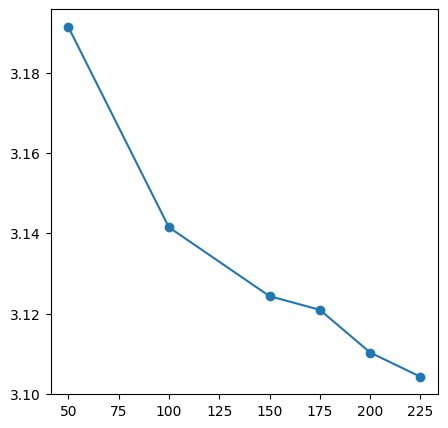

In [20]:
plt.figure(figsize=(5, 5))
plt.plot([x[0] for x in rmse_results], [x[1] for x in rmse_results], marker='o')
plt.show()

#### NMF

In [ ]:
n_components_list = [10, 20, 35, 55, 85, 125]
rmse_results=[]

for n in n_components_list:
    nmf=NMF(n_components=n, init='nndsvd', random_state=42)
    W=nmf.fit_transform(ratings_matrix_complet)
    H=nmf.components_
    ratings_pred=np.dot(W, H)
    ratings_pred_df= pd.DataFrame(ratings_pred, index=ratings_matrix.index, columns=ratings_matrix.columns)

    with open(f'./models/nmf_model_{n}.pkl', 'wb') as f:
        pickle.dump(nmf, f)

    rmse=eval_rmse(ratings_matrix, ratings_pred_df)
    rmse_results.append((n, rmse))
    

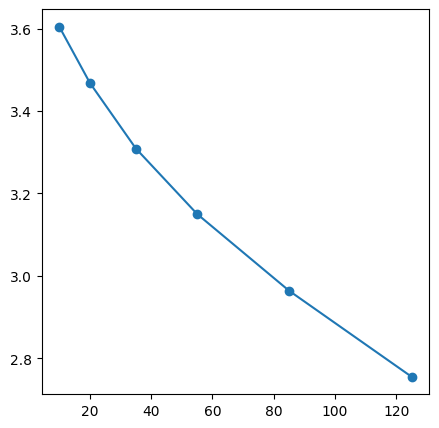

In [36]:
plt.figure(figsize=(5, 5))
plt.plot([x[0] for x in rmse_results], [x[1] for x in rmse_results], marker='o')
plt.show()

### GridSearch

In [22]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV

reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(collaborative_df[['user_id', 'ISBN', 'rating']], reader)

param_grid = {
    'n_factors': [50, 100, 150, 175, 200, 225],
    'lr_all': [0.002, 0.005, 0.01, 0.05],
    'reg_all': [0.02, 0.05, 0.1],
    'n_epochs': [20, 30, 40, 50]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs.fit(data)

print("Meilleur RMSE :", gs.best_score['rmse'])
print("Meilleurs paramètres :", gs.best_params['rmse'])


Meilleur RMSE : 3.050900128509103
Meilleurs paramètres : {'n_factors': 50, 'lr_all': 0.002, 'reg_all': 0.1, 'n_epochs': 20}


In [26]:
# Récupérer les résultats
results = pd.DataFrame.from_dict(gs.cv_results)

# Sauvegarder tous les résultats dans un CSV
results.to_csv('./param/gridsearch_svd_results.csv', index=False)

# Sauvegarder seulement les meilleurs paramètres
best_params = gs.best_params['rmse']
best_score = gs.best_score['rmse']
pd.DataFrame([{'rmse': best_score, **best_params}]).to_csv('./param/best_svd_params.csv', index=False)

## A tester

In [ ]:
title_vec = vectorize(title_tokens)
subject_vec = vectorize(subjects_tokens)
desc_vec = vectorize(description_tokens)

final_vec = (0.4 * title_vec + 0.4 * subject_vec + 0.2 * desc_vec) # poids pour gerer l'influence de chaque partie


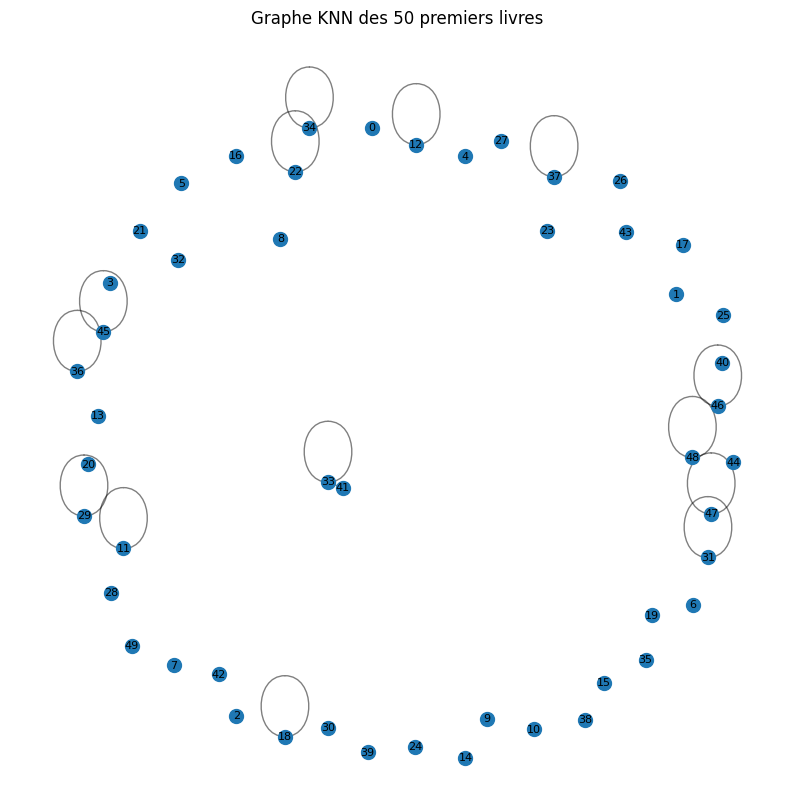

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

subset_indices = list(range(50))  # visualise juste 50 points

G = nx.Graph()

# Ajouter les noeuds
for idx in subset_indices:
    G.add_node(idx)

# Ajouter les arêtes vers les k voisins
for idx in subset_indices:
    distances, neighbors = knn.kneighbors([X[idx]])
    for neighbor in neighbors[0][1:]:  # on saute le premier (c'est lui-même)
        if neighbor in subset_indices:
            G.add_edge(idx, neighbor)

# Dessiner le graphe
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)  # positionnement des noeuds
nx.draw_networkx_nodes(G, pos, node_size=100)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Graphe KNN des 50 premiers livres")
plt.axis('off')
plt.show()

## Ajout des genres et descriptions en utilisant un autre dataset

In [ ]:
import requests

API_URL = "https://api.hardcover.app/v1/graphql"
API_TOKEN = ""  # Remplace par ton token

def test_api_connection():
    query = """
    query {
      me {
        id
        username
      }
    }
    """
    headers = {
        "Authorization": f"Bearer {API_TOKEN}",
        "Content-Type": "application/json"
    }
    response = requests.post(API_URL, json={"query": query}, headers=headers)
    if response.status_code == 200:
        data = response.json()
        if "errors" in data:
            print("Erreur dans la requête GraphQL :", data["errors"])
        else:
            print("Connexion réussie ! Infos utilisateur :")
            print(data["data"]["me"])
    else:
        print(f"Erreur HTTP {response.status_code}: {response.text}")

test_api_connection()


Connexion réussie ! Infos utilisateur :
[{'id': 39049, 'username': 'redyydm'}]


In [ ]:
import requests
import json

API_URL = "https://api.hardcover.app/v1/graphql"
API_TOKEN = ""  # Remplace par ton token

def get_book_genres(slug):
    query = """
    query {
      search(
        query: "$title",
        query_type: "Book",
        per_page: 5,
        page: 1
      ) {
        book {
          title
        }
      }
    }
    """
    headers = {
        "Authorization": f"Bearer {API_TOKEN}",
        "Content-Type": "application/json"
    }
    variables = {"title":slug}

    response = requests.post(API_URL, json={"query": query}, headers=headers)
    if response.status_code == 200:
        data = response.json()
        with open('fichier_export.json', 'w', encoding='utf-8') as f:
          json.dump(data, f, ensure_ascii=False, indent=4)
        docs=data['data']['search']['results']['hits']
        for doc in docs:
            print(doc['document']['genres'])

        
    else:
        print(f"Erreur API: {response.status_code} - {response.text}")
        return None, []
        
get_book_genres("les miserables")


KeyError: 'data'

In [ ]:
def search_book_slug(title):
    query = """
    query ($search: String!) {
      search(query: $search, first: 5) {
        edges {
          node {
            slug
            title
            author_names
          }
        }
      }
    }
    """
    variables = {"search": title}
    headers = {
        "Authorization": f"Bearer {API_TOKEN}",
        "Content-Type": "application/json"
    }

    response = requests.post(API_URL, json={"query": query, "variables": variables}, headers=headers)
    if response.status_code == 200:
        data = response.json()
        results = data.get("data", {}).get("search", {}).get("edges", [])
        # Retourne le premier slug trouvé
        if results:
            return results[0]["node"]["slug"]
        else:
            print(f"Aucun résultat pour '{title}'")
            return None
    else:
        print(f"Erreur API: {response.status_code} - {response.text}")
        return None

## Ajout des genres et descriptions des livres via API google books (si possible)

In [4]:
import requests
import time

def get_book_info(isbn, api_key=None):
    base_url = 'https://www.googleapis.com/books/v1/volumes'
    params = {
        'q': f'isbn:{isbn}',
    }
    if api_key:
        params['key'] = api_key

    response = requests.get(base_url, params=params)
    if response.status_code != 200:
        return None

    data = response.json()
    items = data.get('items')
    if not items:
            return {
                 'title': None,
                'author': None,
                'categories': None,
                'description': None,
            }

    volume_info = items[0]['volumeInfo']
    return {
        'title': volume_info.get('title'),
        'author': volume_info.get('authors'),
        'categories': volume_info.get('categories'),
        'description': volume_info.get('description'),
    }

In [ ]:
books_df = pd.read_csv(path+'Books.csv')
books_df.rename(columns={'Book-Title':'title', 'Book-Author': 'author'}, inplace=True)
books_df.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], inplace=True)
enriched_data = []

for idx, row in books_df.head(10).iterrows():
    isbn = row['ISBN']
    info = get_book_info(isbn, '') 
    enriched_data.append(info)
    time.sleep(0.1) 

enriched_df = pd.DataFrame(enriched_data)

enriched_df

,0
0,None
1,None
2,None
3,None
4,None
5,None
6,None
7,None
8,None
9,None


In [33]:
books_df

,ISBN,title,author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [34]:
books_df_enriched=books_df.merge(enriched_df, on='title')
books_df_enriched

,ISBN,title,author_x,Year-Of-Publication,Publisher,author_y,categories,description
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,"[Mark P. O. Morford, Robert J. Lenardon]",[Social Science],Provides an introduction to classical myths pl...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,[Richard Bruce Wright],[Actresses],"In a small town in Canada, Clara Callan reluct..."
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,[Carlo D'Este],[History],"Here, for the first time in paperback, is an o..."
3,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,[Amy Tan],[Fiction],An absorbing narrative of Winnie Louie's life.
4,0771074670,Nights Below Station Street,David Adams Richards,1988,Emblem Editions,[David Adams Richards],[Fiction],Another story based in the fictional rural tow...
...,...,...,...,...,...,...,...,...
203,0872203166,The Prince,Niccolo Machiavelli,1995,Hackett Publishing Company,[Niccolò Machiavelli],[Political ethics],"Notes, a 2-page map, an index, and an altogeth..."
204,0226500446,The Prince,Niccolo Machiavelli,1998,Press,[Niccolò Machiavelli],[Political ethics],"Notes, a 2-page map, an index, and an altogeth..."
205,0897110080,Black Beauty,Anna Sewell,1975,Worlds Great Classics,"[Anna Sewell, Ron Huron]",[Juvenile Fiction],A horse in nineteenth-century England recounts...
206,0895310619,Black Beauty,Anna Sewell,1981,Sharon Pubns,"[Anna Sewell, Ron Huron]",[Juvenile Fiction],A horse in nineteenth-century England recounts...
